#**제4회 2023 연구개발특구 AI SPARK 챌린지 - 공기압축기 이상 판단**

#대회 주제

- 제4회 연구개발특구 AI SPARK 챌린지는 **산업기기 피로도를 예측**하는 문제입니다.
- 산업용 공기압축기 및 회전기기에서 모터 및 심부 온도, 진동, 노이즈 등은 기기 피로도에 영향을 주는 요소이며, 피로도 증가는 장비가 고장에 이르는 원인이 됩니다.
- 피로도 증가 시 데이터 학습을 통해 산업기기 이상 전조증상을 예측하여 기기 고장을 예방하고 그로 인한 사고를 예방하는 모델을 개발하는 것이 이번 대회의 목표입니다.

#모델 조건

1. 본 대회의 모델링은 **비지도학습 방식**으로 진행됩니다.

2. 향후 실시간 판정에 활용될 수 있도록, 개발된 모델은 다음의 조건을 충족하여야 합니다.

- 입력된 데이터를 정상(0), 이상(1)로 구분하는 **이진 분류 모델**이어야 합니다.
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델이어야 합니다.
- 신규 데이터로 학습/개선이 가능한 모델이어야 합니다.
-총 8개의 대상 설비를 모델링하면서, **설비별로 별도의 모델을 학습하는 것은 허용되나 모두 동일한 아키텍처를 사용해야 합니다.**
(예: 설비 1에 사용한 모델 구조를 나머지 설비에도 사용하여야 함)
 

# 1.라이브러리 호출

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
pip install skompiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for skompiler: filename=SKompiler-0.7-py3-none-any.whl size=54330 sha256=7567d7979b1eb8471880eacb42c6970b8dec33d60b016d6c80a3606c4c429755
  Stored in directory: /root/.cache/pip/wheels/c0/e1/03/f278ce2f21aa5454220562b438f1f78c44f63fd1f5ceb08063
Successfully built skompiler


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,ShuffleSplit,GridSearchCV
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs,make_moons
from yellowbrick.cluster import KElbowVisualizer
import time
from matplotlib.colors import ListedColormap
from skompiler import skompile
from joblib import dump, load                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


## Load Data

- train_data: 학습용 데이터로 모두 정상 case로 이루어진 데이터입니다.
- test_data: 평가용 데이터로 정상 case와 이상 case가 함께 포함되어 있는 데이터로, 예측 대상에 해당됩니다.
- answer_sample: test_data에 대하여 작성할 제출용 레이블 파일 양식입니다.

In [ ]:
df_train = pd.read_csv( '/content/drive/MyDrive/공모전/dataset/train_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/공모전/dataset/test_data.csv')
df_train.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [ ]:
df1 = df_train.sample(10)
df1

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
1458,3.68,46.75,0.7,43.00,2100.0,64.33,4.37,3
388,2.14,48.36,0.7,27.73,2269.0,65.21,3.26,0
1721,3.33,64.08,0.7,43.10,3526.0,79.18,3.96,4
2089,2.71,55.84,0.7,35.04,2867.0,71.86,3.59,6
635,1.92,59.06,0.7,28.29,3285.0,74.50,3.63,1
1764,1.96,45.89,0.7,25.31,2071.0,63.01,3.15,4
129,1.65,41.90,0.7,21.41,1752.0,59.47,2.97,0
794,1.58,51.86,0.7,23.33,2709.0,68.10,3.31,1
1847,2.67,55.30,0.7,34.52,2824.0,71.38,3.57,5
1173,3.52,45.65,0.7,41.00,2012.0,63.36,4.32,3


# 2.Original Feature 분석

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [ ]:
df_train.describe().T 

,count,mean,std,min,25%,50%,75%,max
air_inflow,2463.0,2.128843,1.202328e+00,0.33,1.28,1.96,2.820,6.22
air_end_temp,2463.0,49.001137,8.725091e+00,32.03,41.60,48.98,56.355,64.96
out_pressure,2463.0,0.700000,1.110448e-16,0.70,0.70,0.70,0.700,0.70
motor_current,2463.0,27.490715,1.360460e+01,5.34,17.11,25.85,36.000,72.00
motor_rpm,2463.0,2372.576939,6.878708e+02,1201.00,1784.50,2358.00,2971.000,3564.00
motor_temp,2463.0,65.766707,7.797152e+00,50.36,59.15,65.64,72.275,80.52
motor_vibe,2463.0,3.452972,1.576386e+00,1.97,2.88,3.26,3.730,21.87
type,2463.0,2.957369,2.230113e+00,0.00,1.00,3.00,5.000,7.00


## Train Data Column 설명

air_inflow: 공기 흡입 유량 (^3/min)

air_end_temp: 공기 말단 온도 (°C)

out_pressure: 토출 압력 (Mpa)

motor_current: 모터 전류 (A)

motor_rpm: 모터 회전수 (rpm)

motor_temp: 모터 온도 (°C)

motor_vibe: 모터 진동 (mm/s)

type: 설비 번호



---


설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

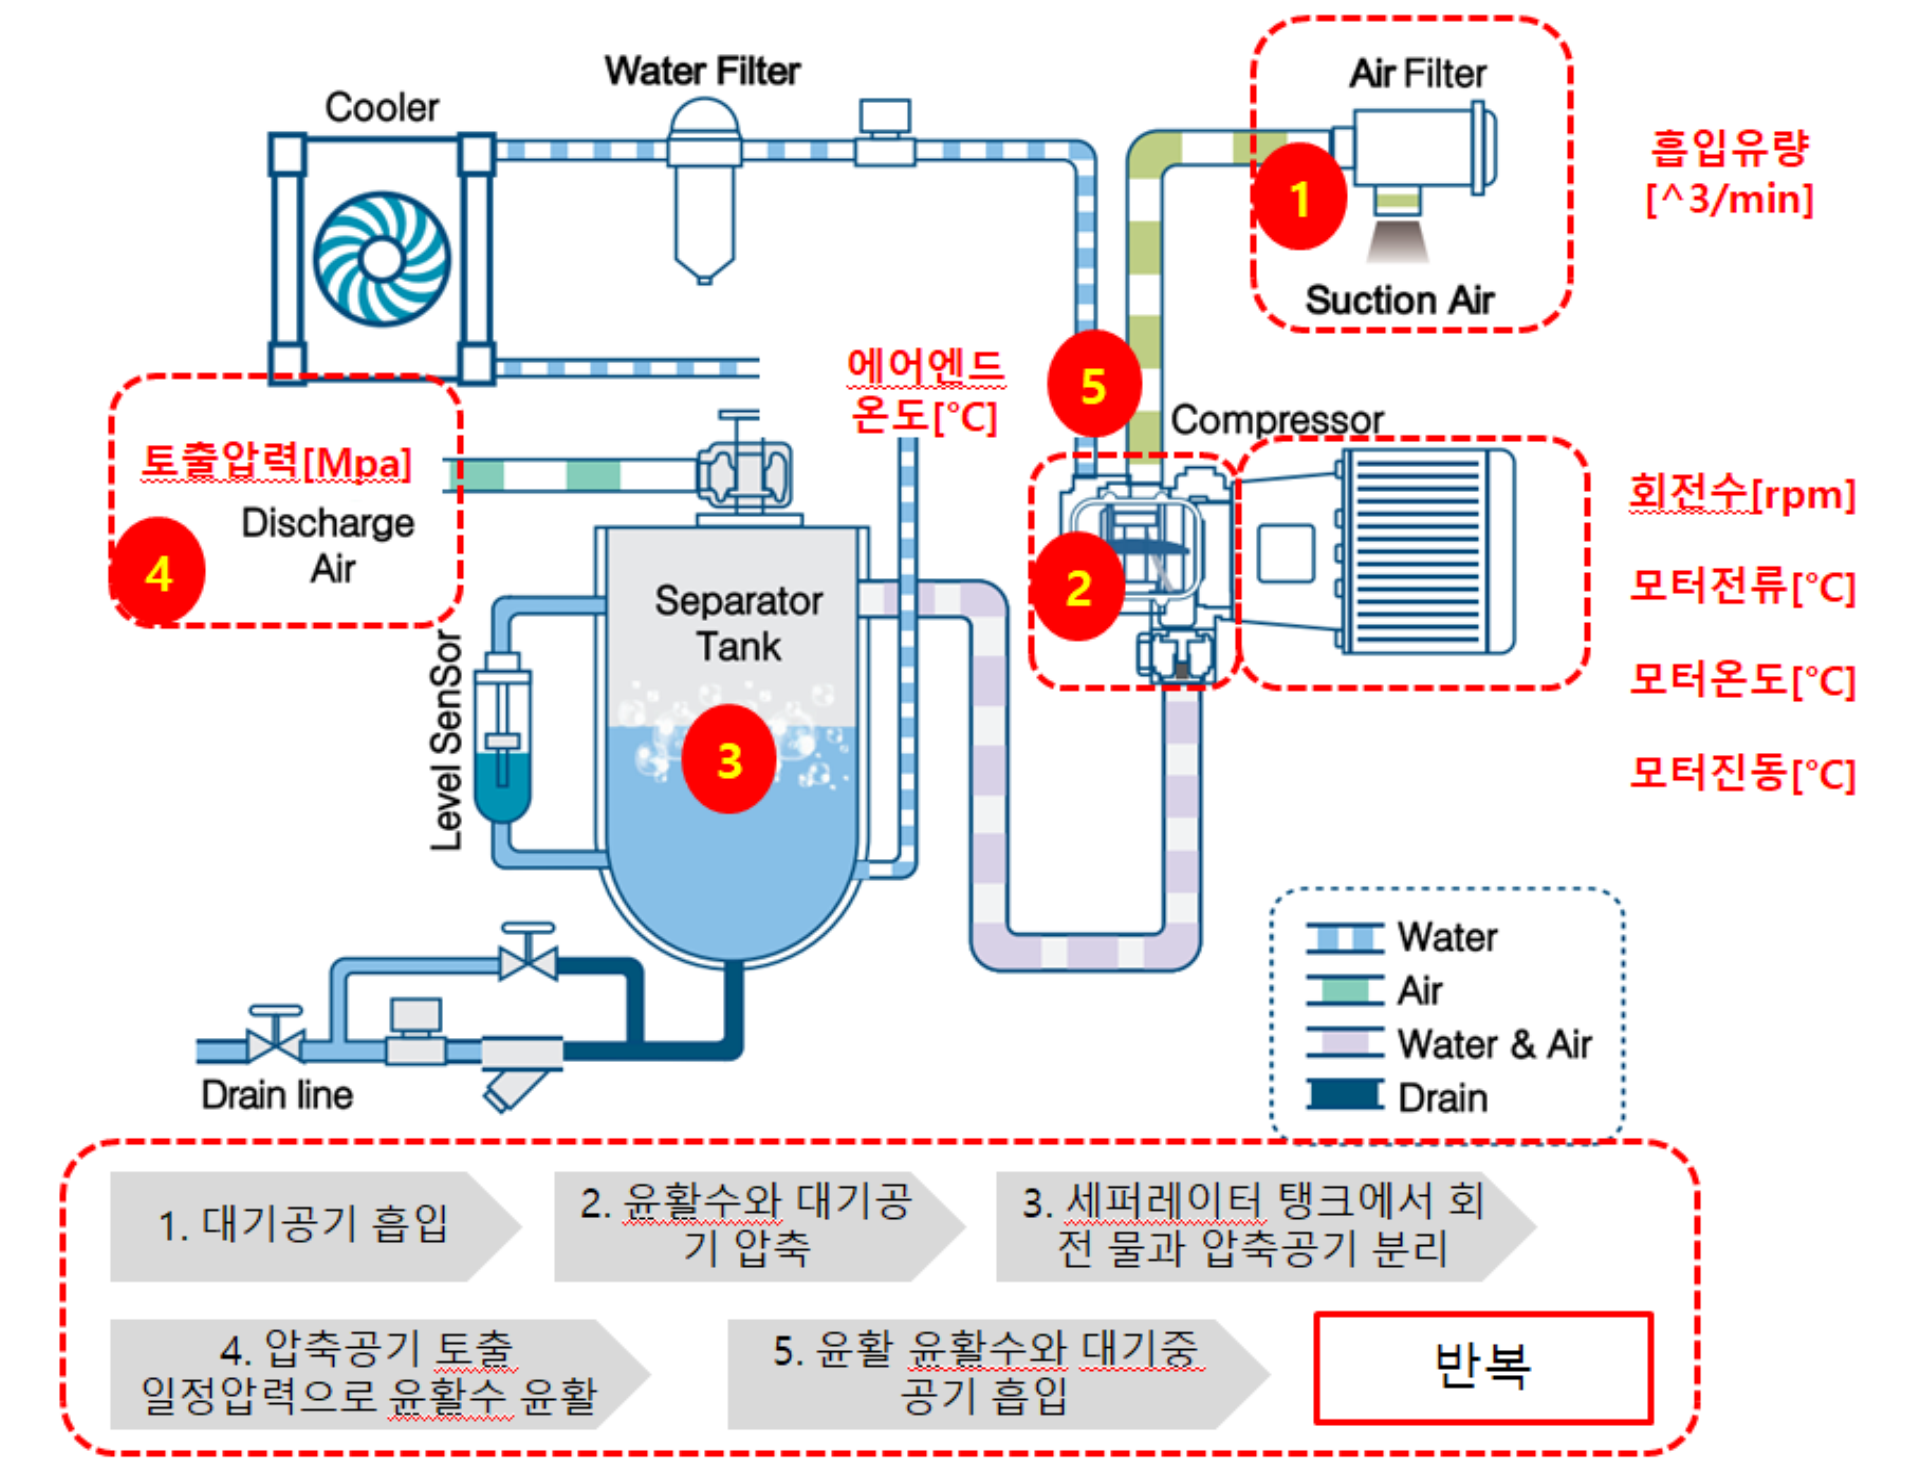

#3.데이터 전처리


## 결측치 확인

In [ ]:
df_train.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
type             0
dtype: int64

In [ ]:
df_test.isnull().sum()

air_inflow       0
air_end_temp     0
out_pressure     0
motor_current    0
motor_rpm        0
motor_temp       0
motor_vibe       0
type             0
dtype: int64

## Outiler 확인

###  type(0~7)별로 그룹 만들기

In [ ]:
df_train.value_counts("type")

type
0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
dtype: int64

In [ ]:
# 빈 딕셔너리 생성
ty_train = {}

# 0부터 7까지의 type 값에 해당하는 데이터프레임을 따로 저장
for i in range(8):
    ty_train[i] = df_train[df_train['type'] == i]

In [ ]:
ty_train[3]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
1167,4.73,54.30,0.7,55.0,2704.0,71.04,4.70,3
1168,5.65,60.83,0.7,65.0,3226.0,76.84,4.99,3
1169,2.45,37.99,0.7,28.0,1399.0,56.54,3.98,3
1170,5.86,62.33,0.7,68.0,3346.0,78.18,5.06,3
1171,4.43,52.15,0.7,51.0,2532.0,69.13,4.61,3
...,...,...,...,...,...,...,...,...
1468,4.77,54.56,0.7,55.0,2725.0,71.28,4.71,3
1469,5.51,59.86,0.7,64.0,3149.0,75.99,4.95,3
1470,3.11,42.70,0.7,36.0,1776.0,60.73,4.19,3
1471,5.46,59.51,0.7,63.0,3121.0,75.68,4.93,3


In [ ]:
ty0_train = df_train[df_train["type"] == 0]
ty0_train = pd.DataFrame(ty0_train)
ty0_train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
427,1.32,37.49,0.7,17.10,1399.0,55.54,2.78,0
428,1.80,43.85,0.7,23.32,1908.0,61.20,3.06,0
429,2.79,56.99,0.7,36.17,2959.0,72.88,3.64,0
430,2.25,49.79,0.7,29.13,2383.0,66.48,3.32,0


### column별로 박스플롯 그래프

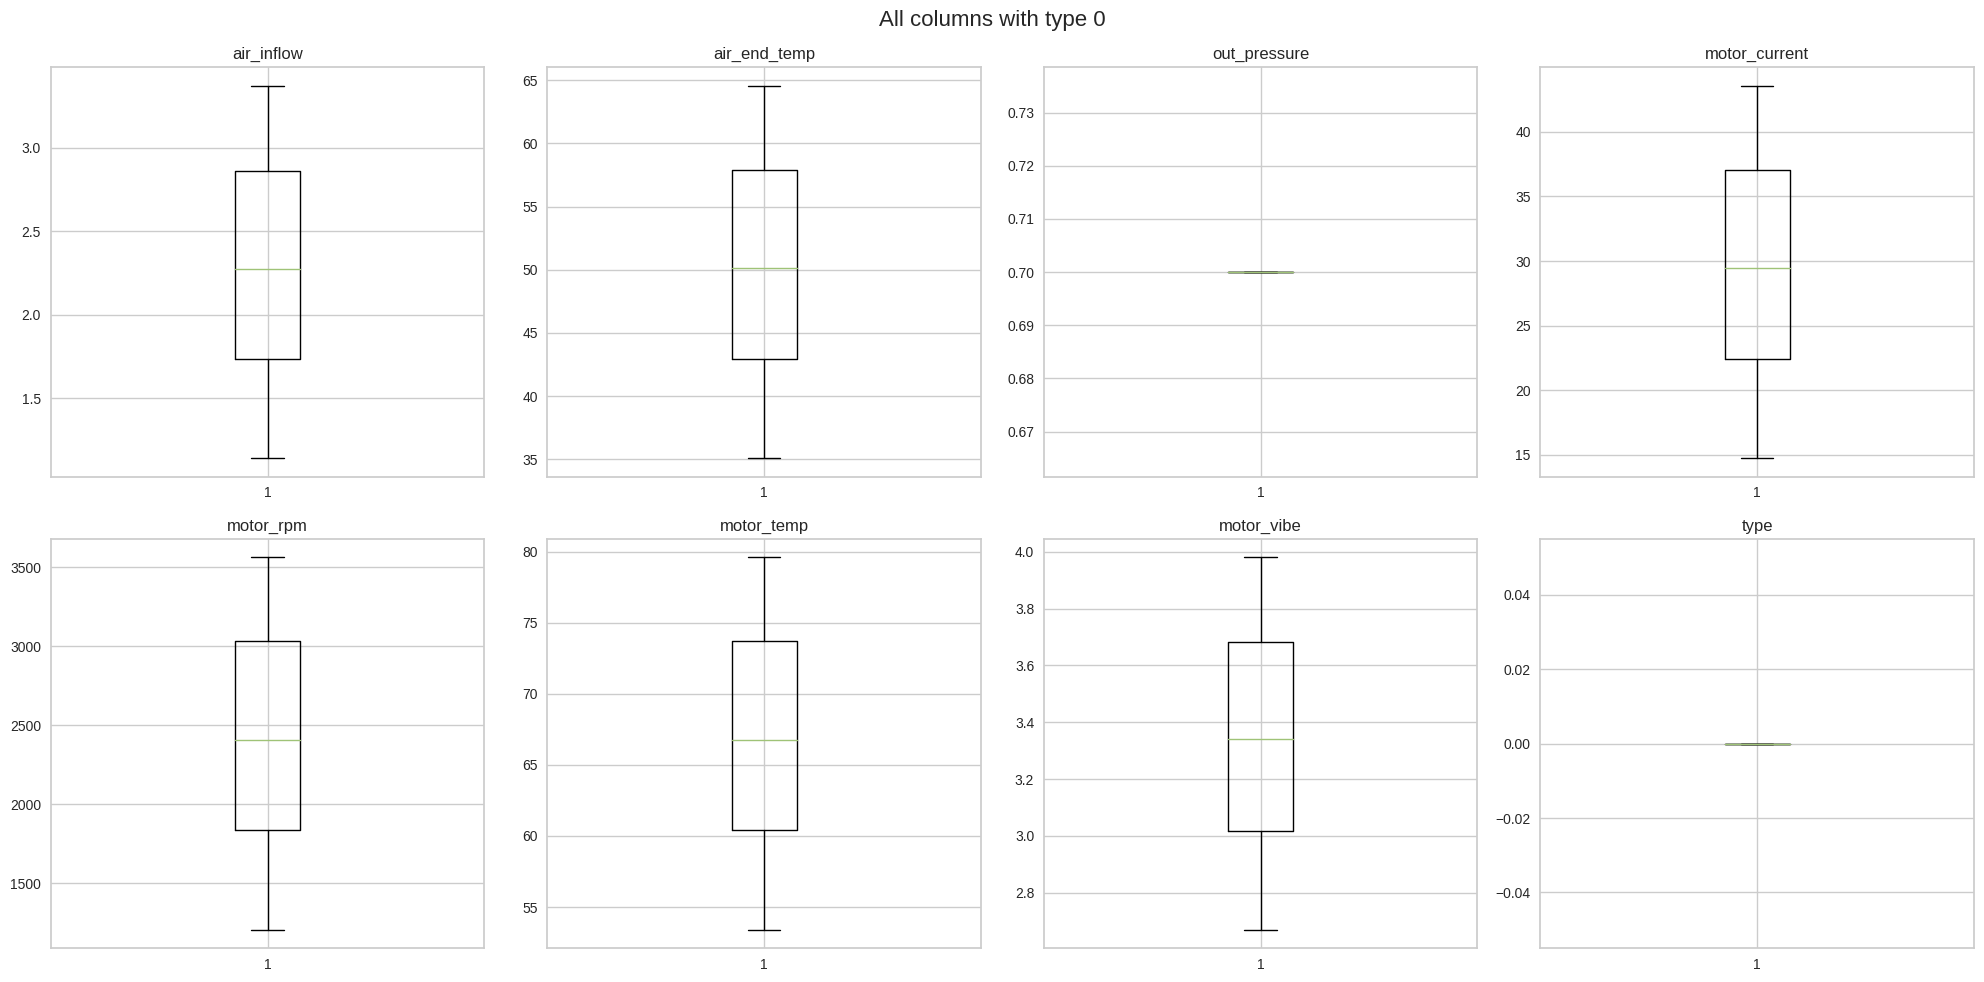

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[0]):
    if col in ty_train[0]:
        ax.boxplot(ty_train[0][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 0', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

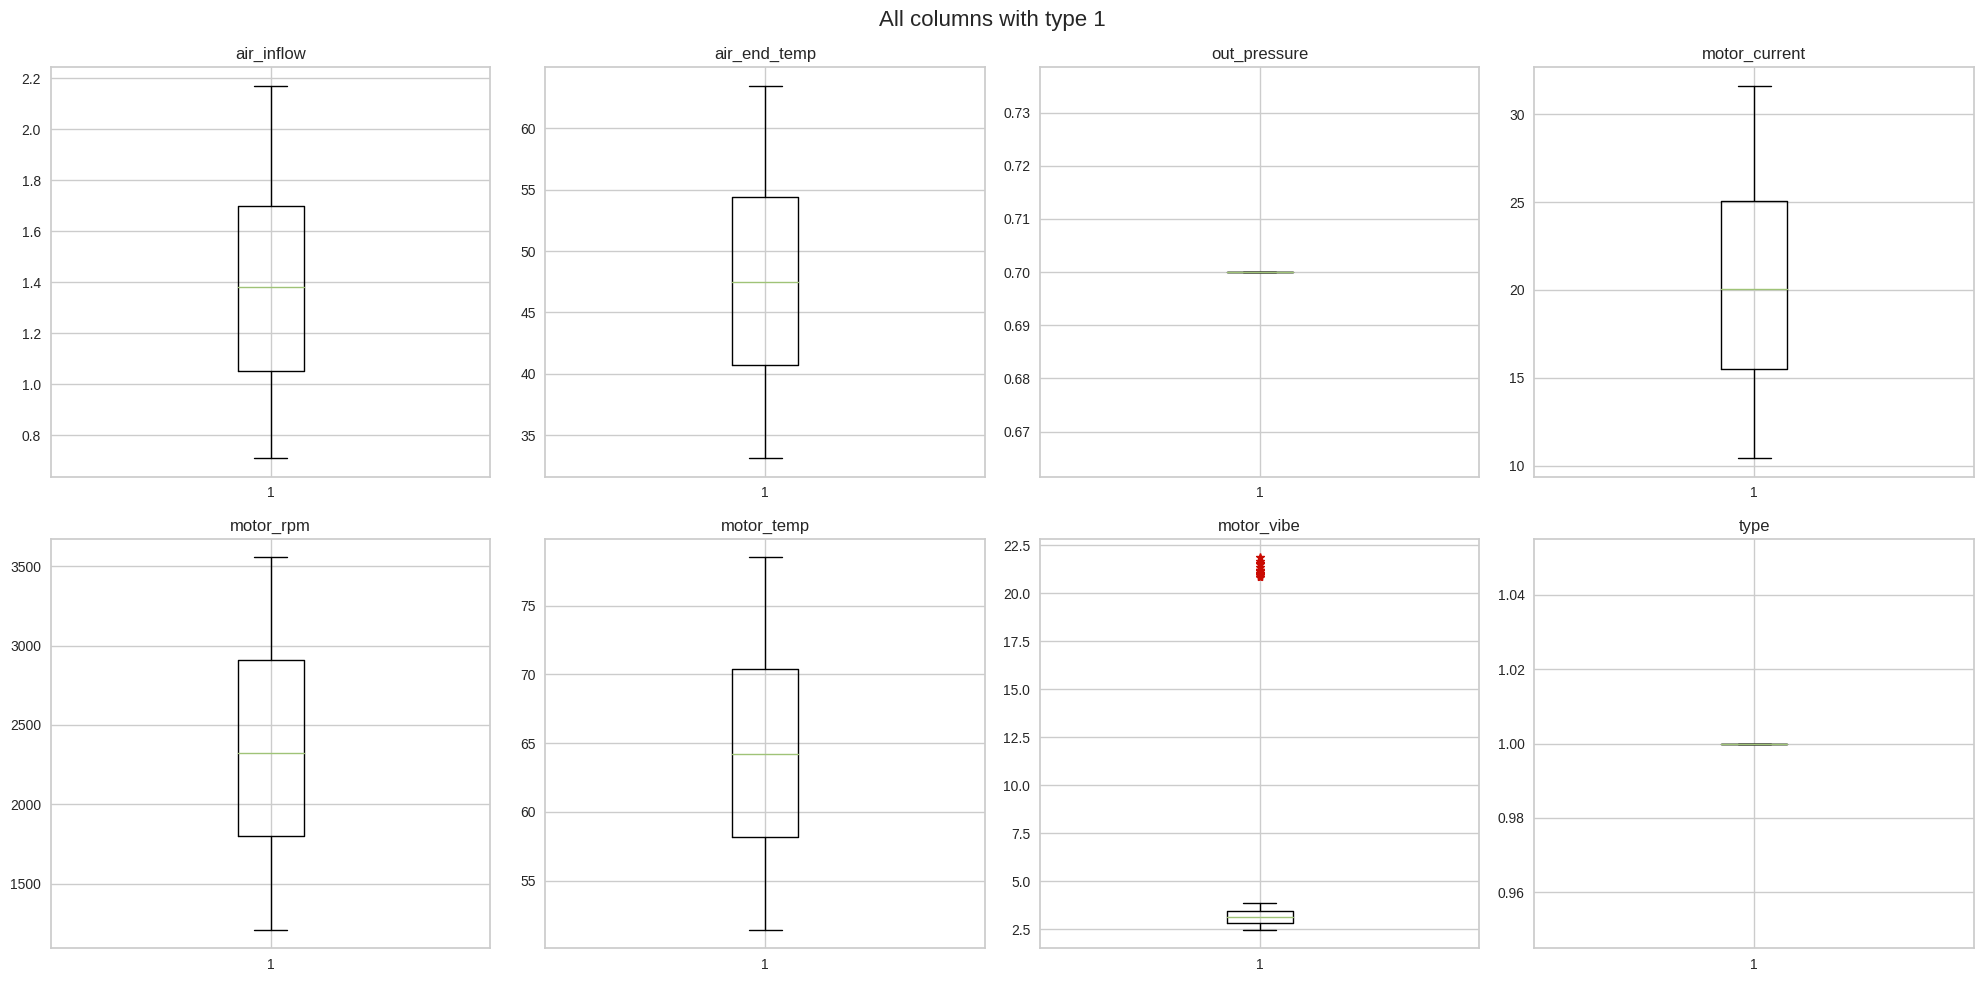

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[1]):
    if col in ty_train[1]:
        ax.boxplot(ty_train[1][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 1', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

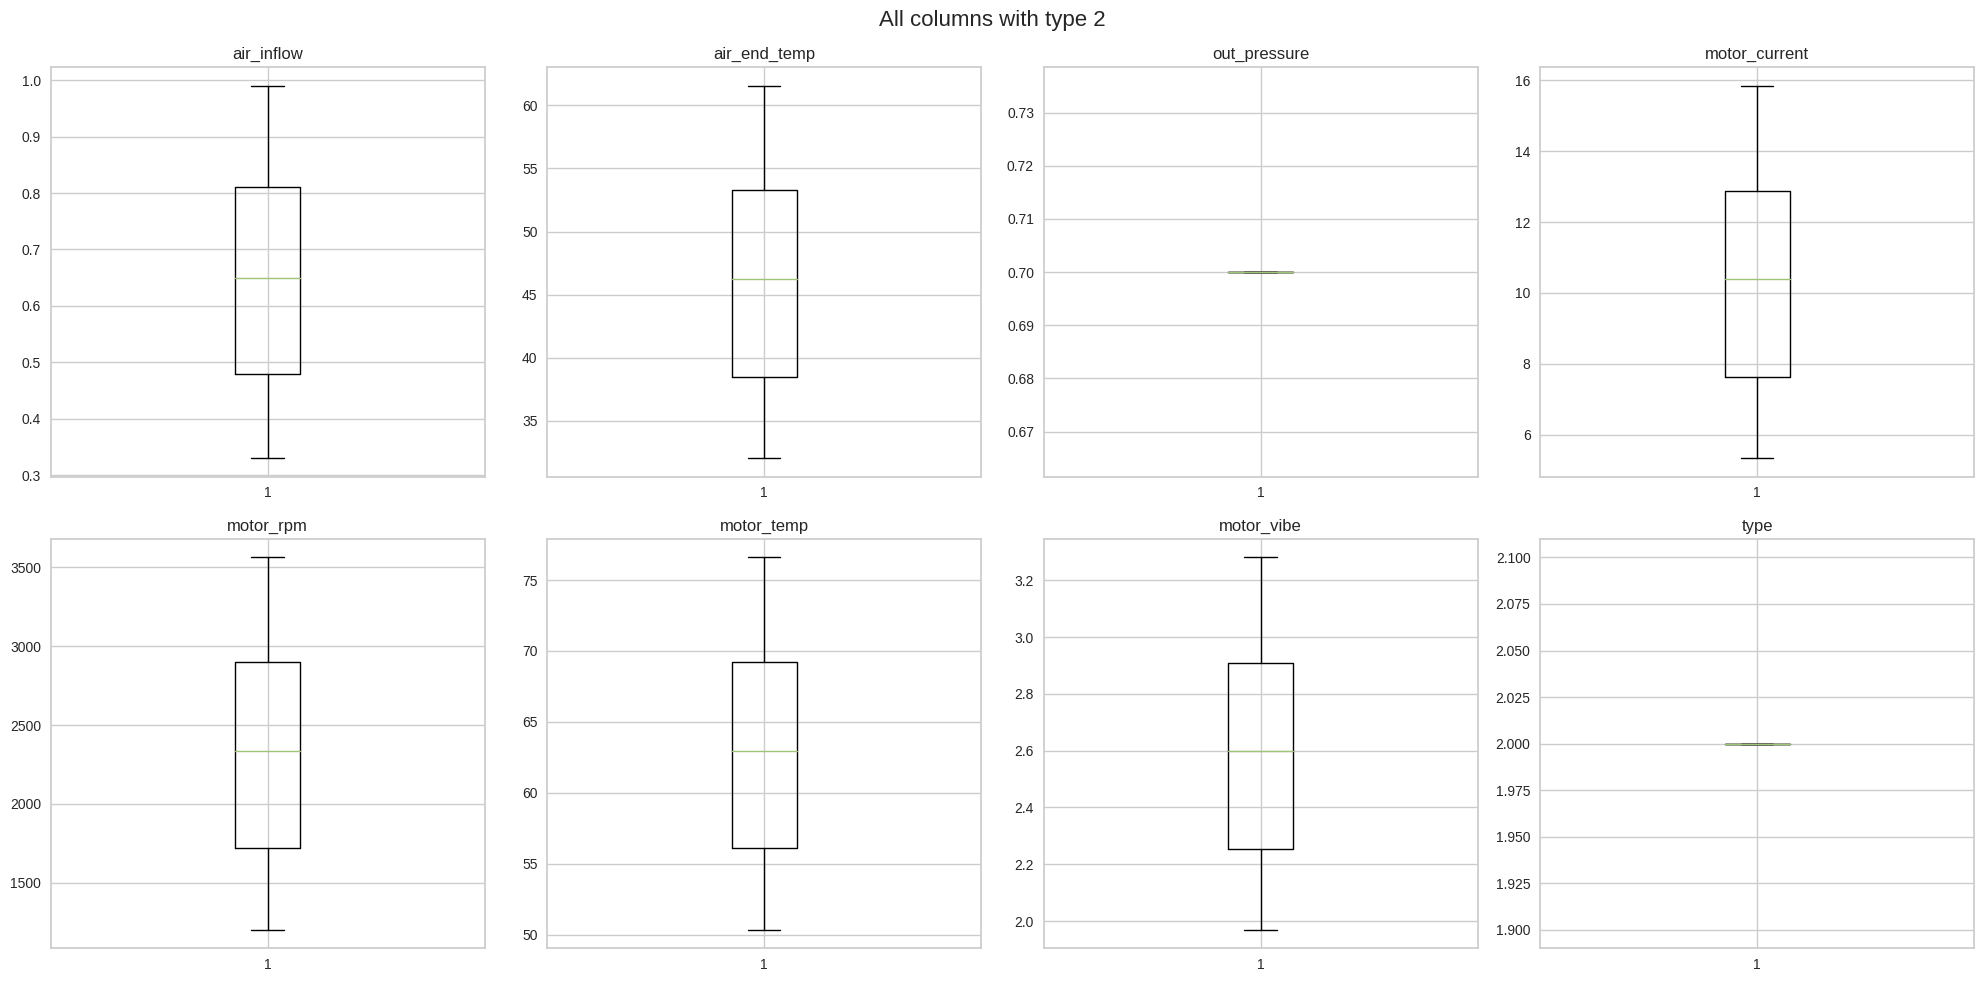

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[2]):
    if col in ty_train[2]:
        ax.boxplot(ty_train[2][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 2', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

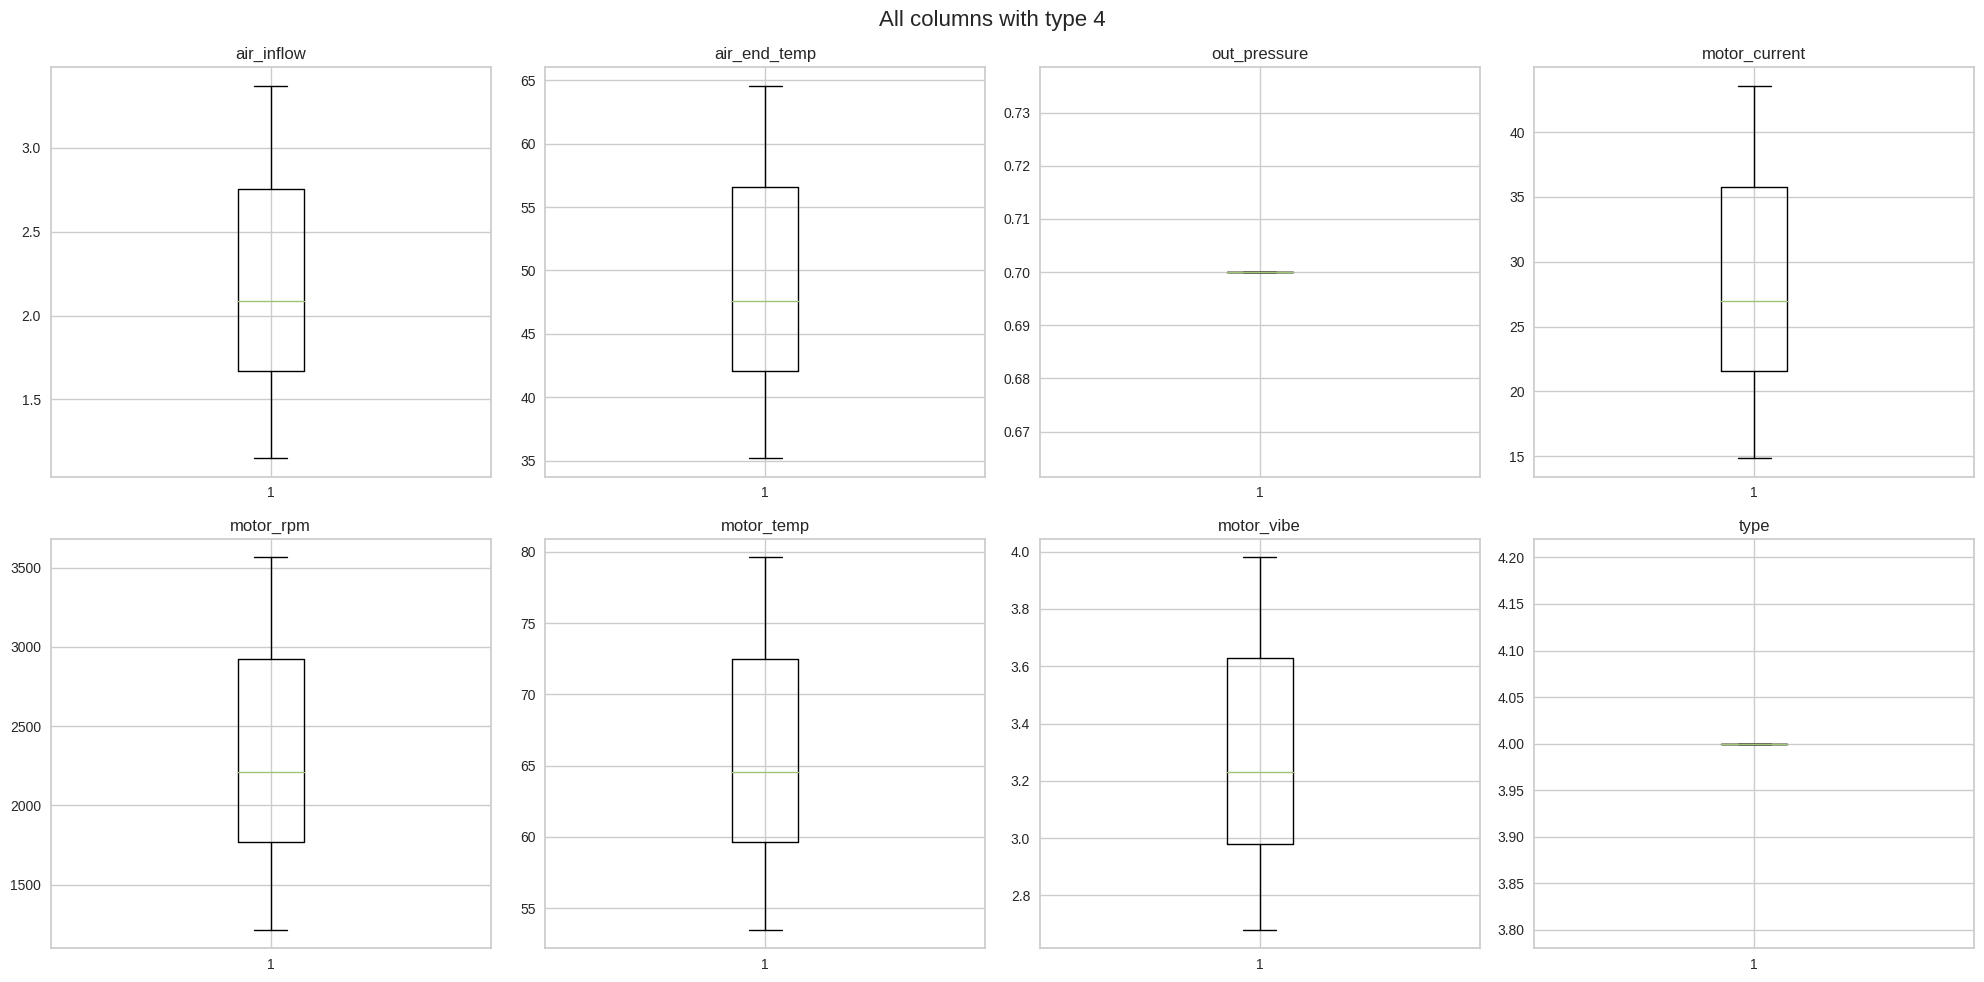

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[4]):
    if col in ty_train[4]:
        ax.boxplot(ty_train[4][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 4', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

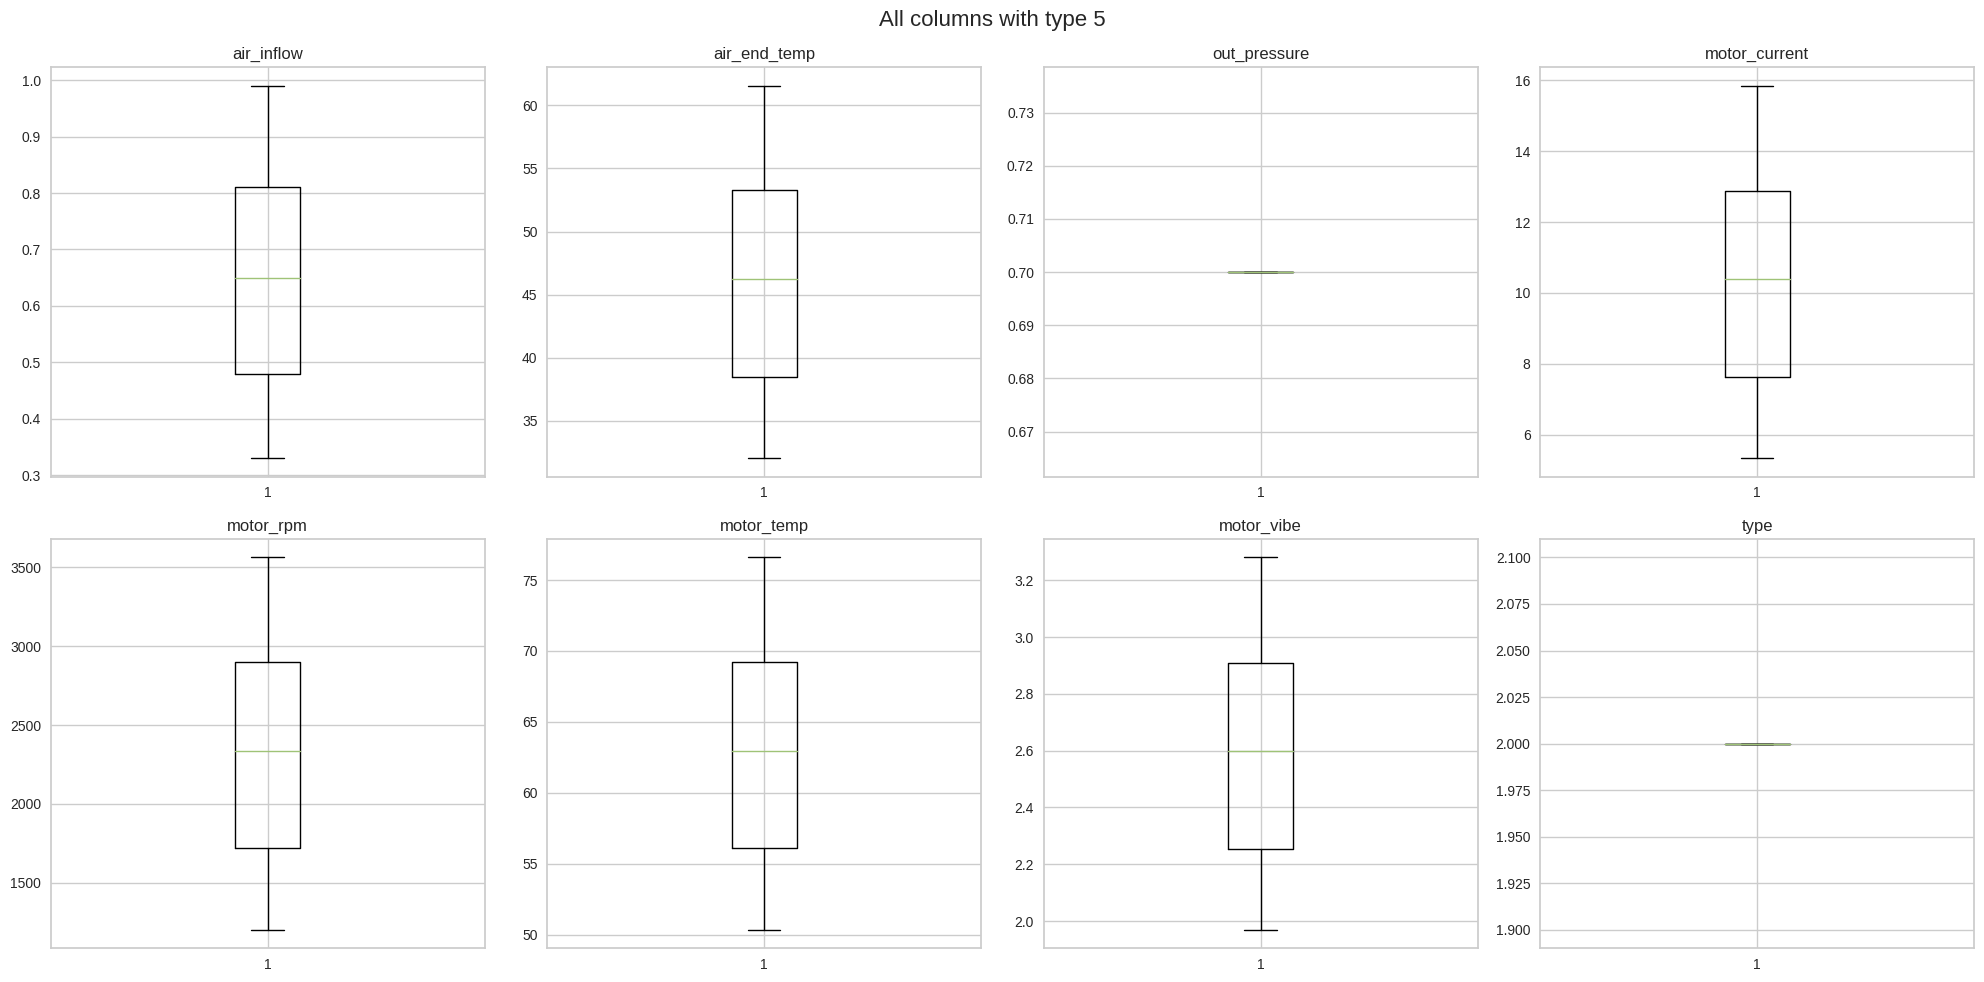

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[2]):
    if col in ty_train[2]:
        ax.boxplot(ty_train[2][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 5', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

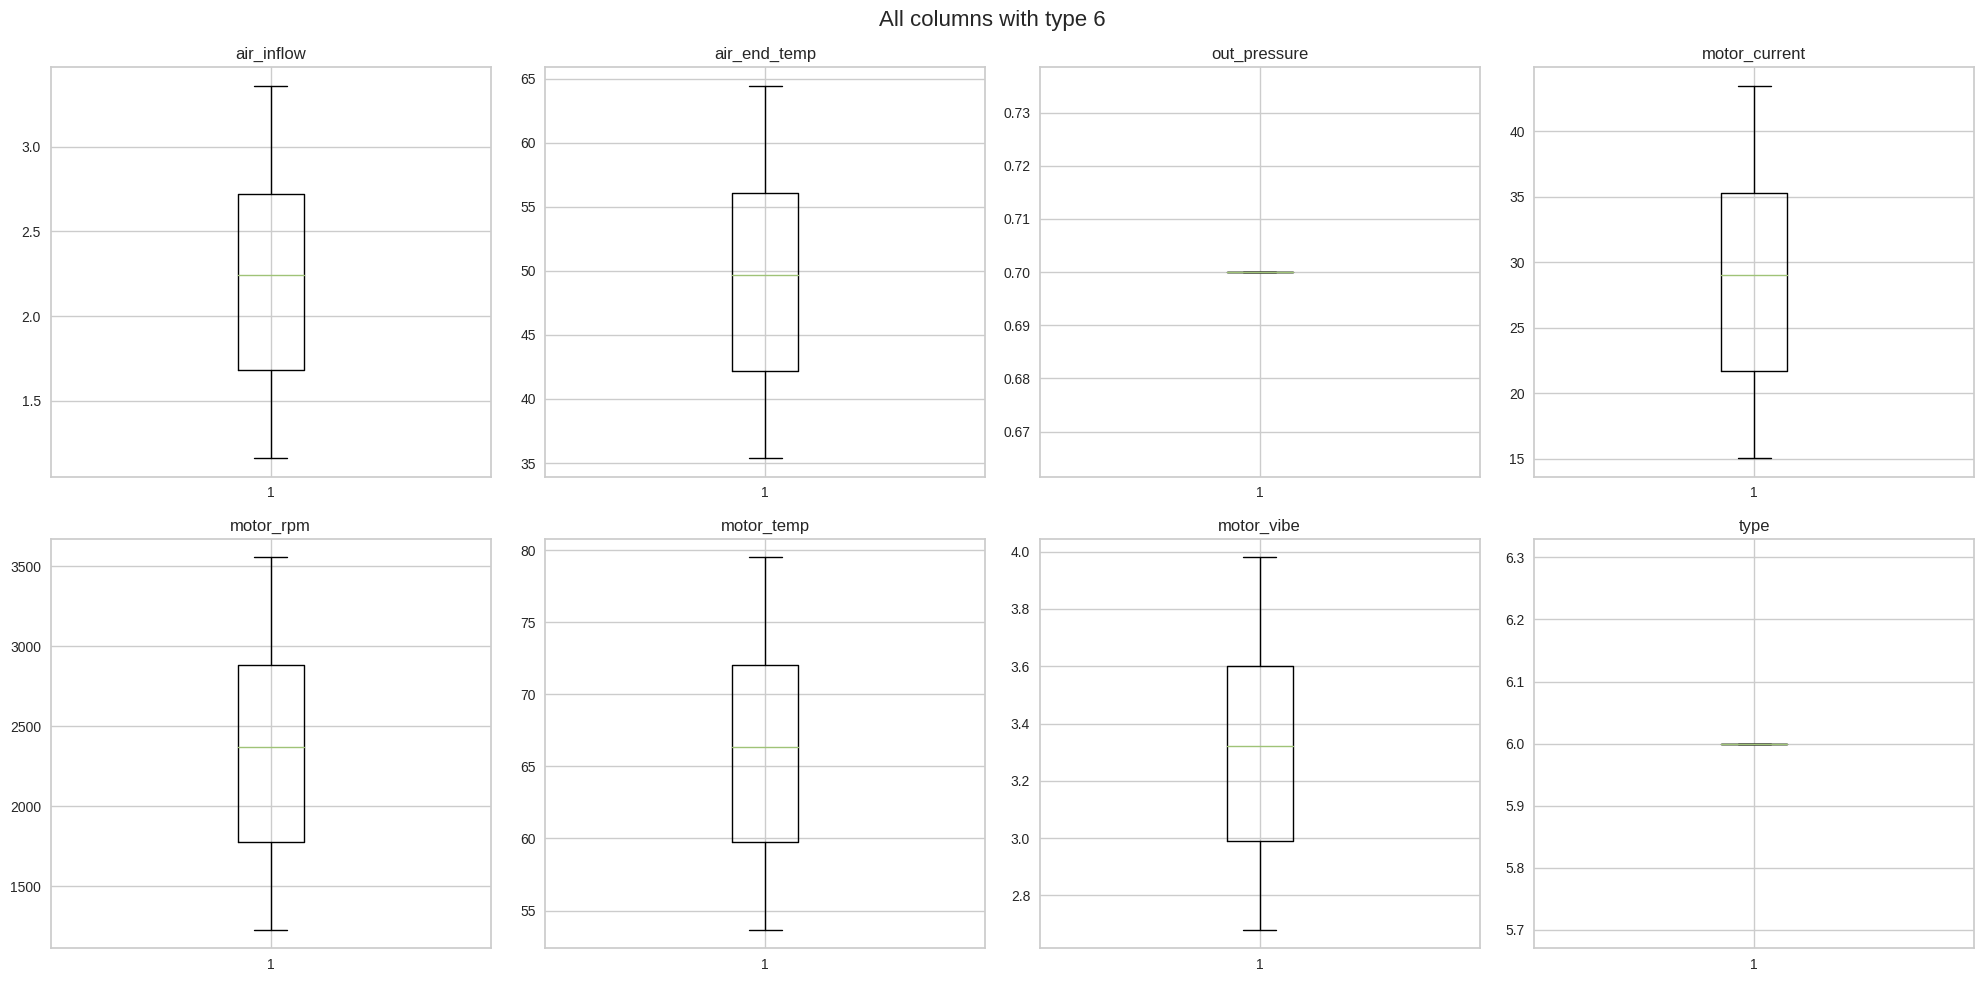

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[6]):
    if col in ty_train[6]:
        ax.boxplot(ty_train[6][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 6', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

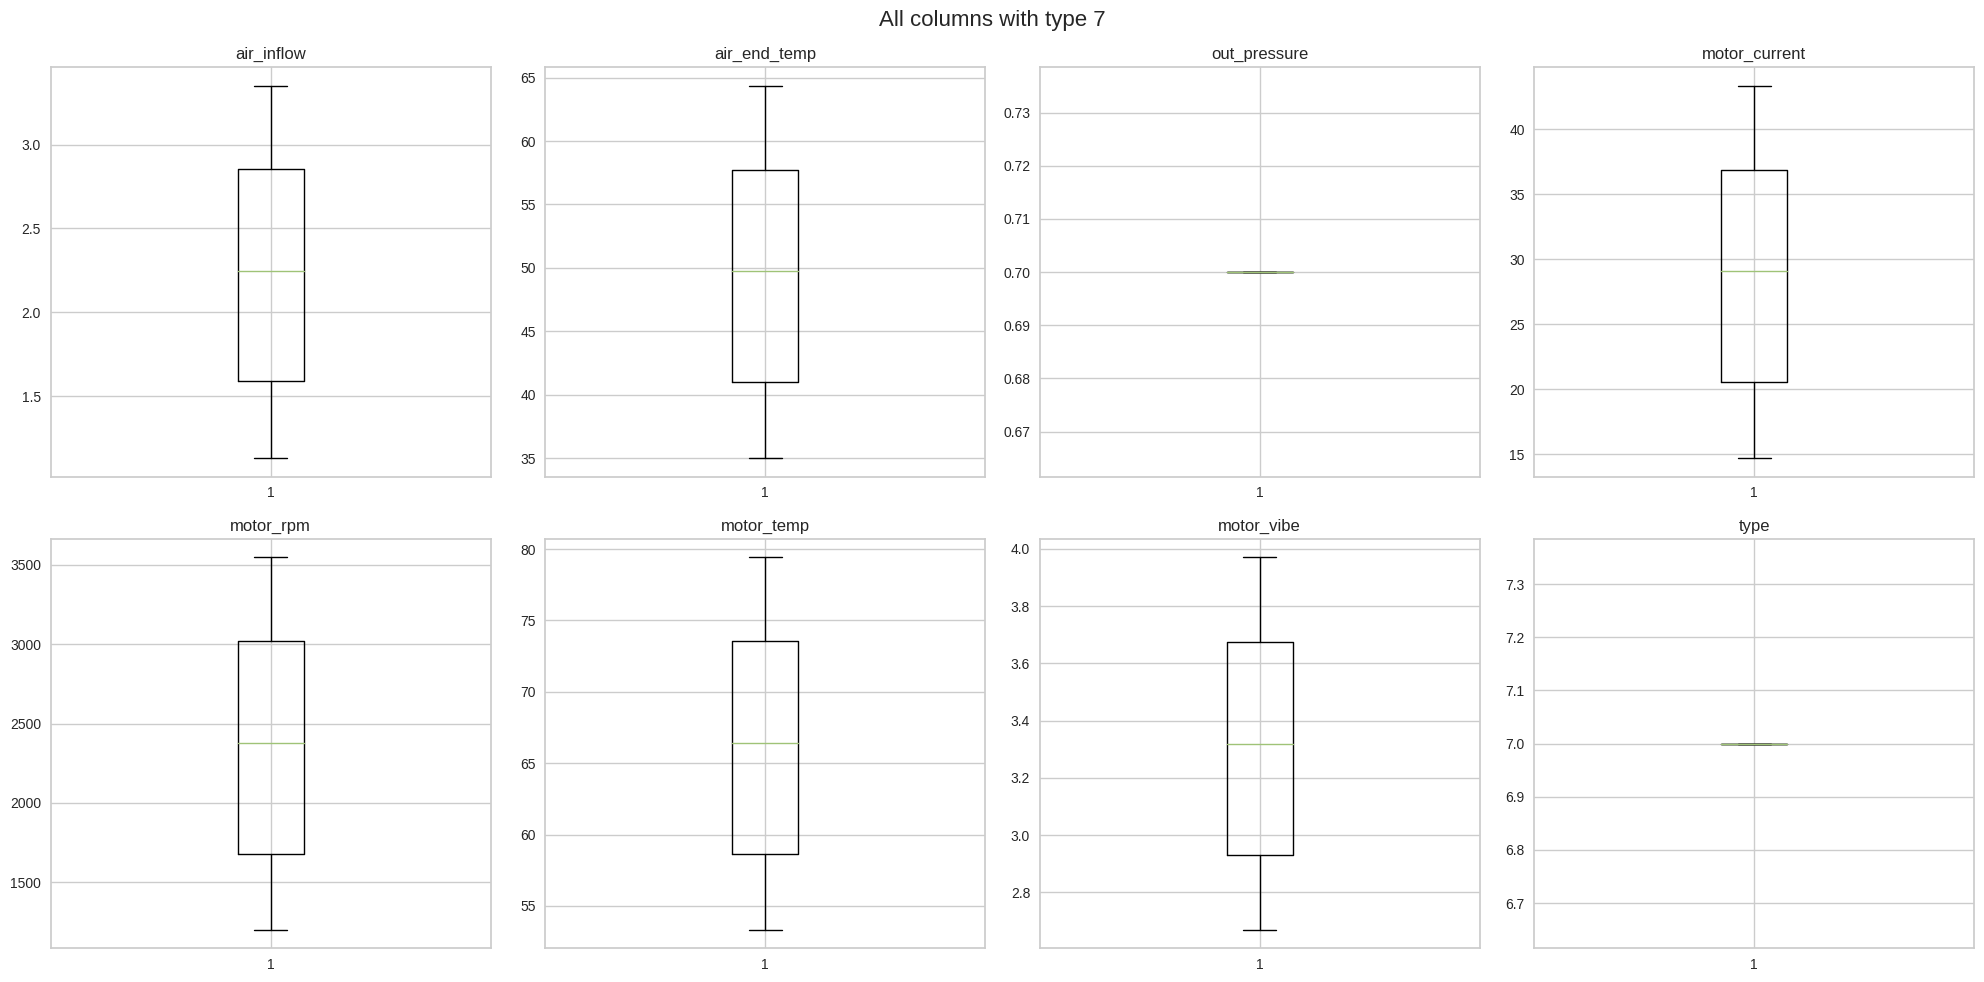

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for ax, col in zip(axes.flatten(), ty_train[7]):
    if col in ty_train[7]:
        ax.boxplot(ty_train[7][col], sym='r*')   #sym='r*'는 이상치(outlier)들을 빨간색 별표로 표시하도록 지정
        ax.set_title(col, size = 12)
plt.suptitle('All columns with type 7', fontsize=16)
plt.tight_layout() # subplot의 레이아웃이 자동으로 최적화되어 더 나은 시각화를 가능
plt.show()

### type- cloumns 산점도 그래프

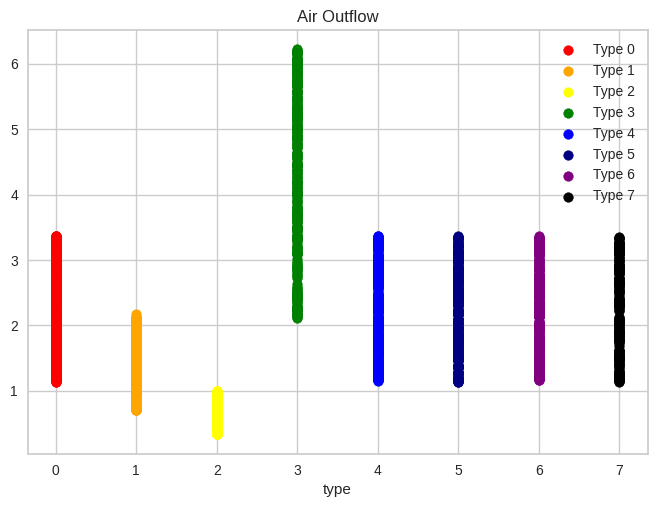

In [ ]:
# "type" 값에 따른 색상 설정
color_dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'navy', 6: 'purple', 7: 'black'}

# 산점도 그래프 그리기
for i in range(8):
    plt.scatter(df_train[df_train['type'] == i]['type'], df_train[df_train['type'] == i]['air_inflow'], color=color_dict[i], label='Type {}'.format(i))

# 그래프 축과 타이틀 설정
plt.xlabel('type')
plt.title('Air Outflow')

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()


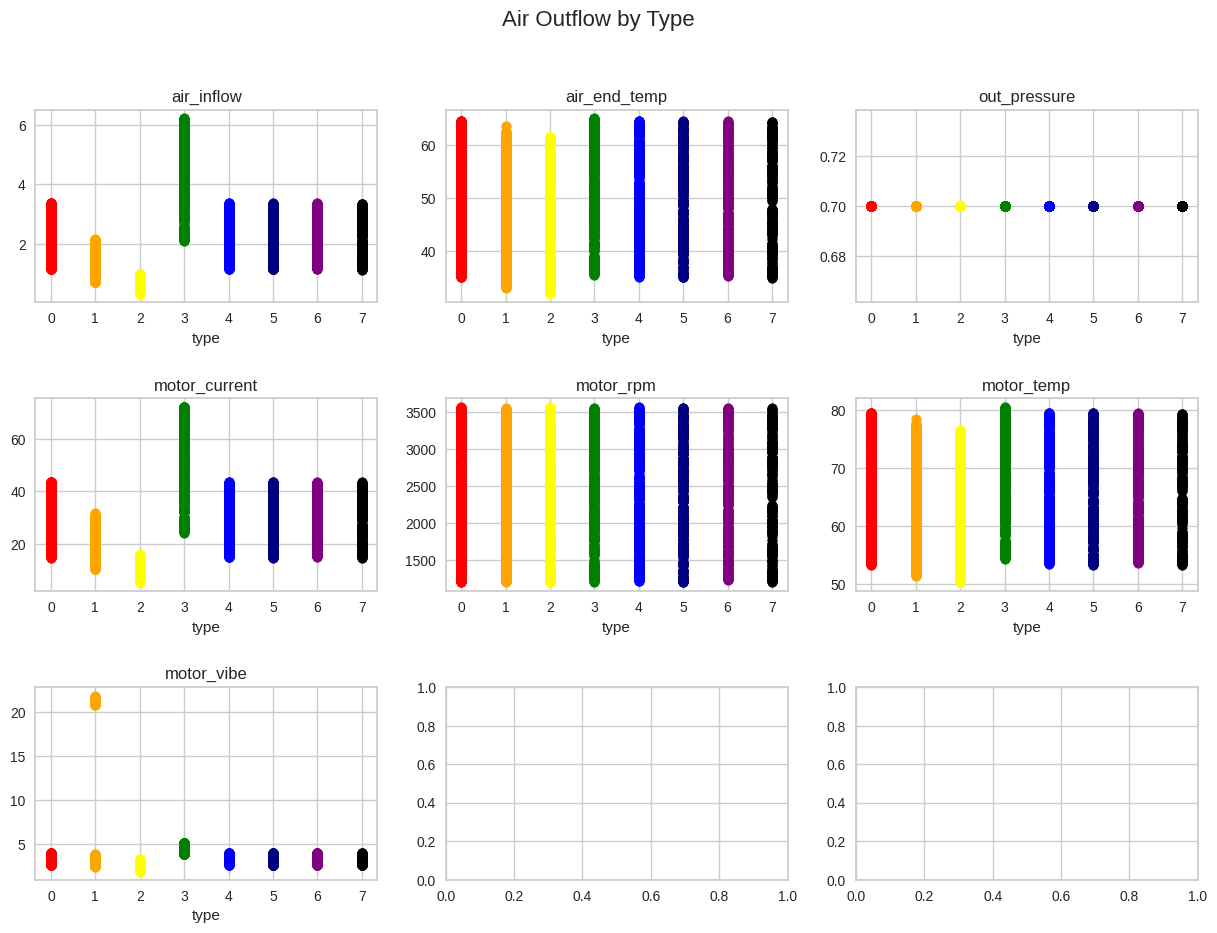

In [ ]:
color_dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'navy', 6: 'purple', 7: 'black'}
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i in range(8):
    for j, col in enumerate(df_train.columns):
        if col == 'type':
            continue
        ax = axes.flatten()[j]
        ax.scatter(df_train[df_train['type'] == i]['type'], df_train[df_train['type'] == i][col], color=color_dict[i], label='Type {}'.format(i))
        ax.set_xlabel('type')
        ax.set_title(col, size =12)
plt.suptitle('Air Outflow by Type', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.legend()
plt.show()

# 4.K-means Clustering


## K-평균 군집화 알고리즘 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 두 가지 feature를 대상
data = df_train[['air_end_temp', 'motor_temp']]

scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

## 파이썬 사이킷런 K-means 클러스터링 알고리즘 학습

In [ ]:
from sklearn.cluster import KMeans

k = 8

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df_train['cluster'] = model.fit_predict(data_scale)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 파이썬 K-means 군집화 결과 시각화

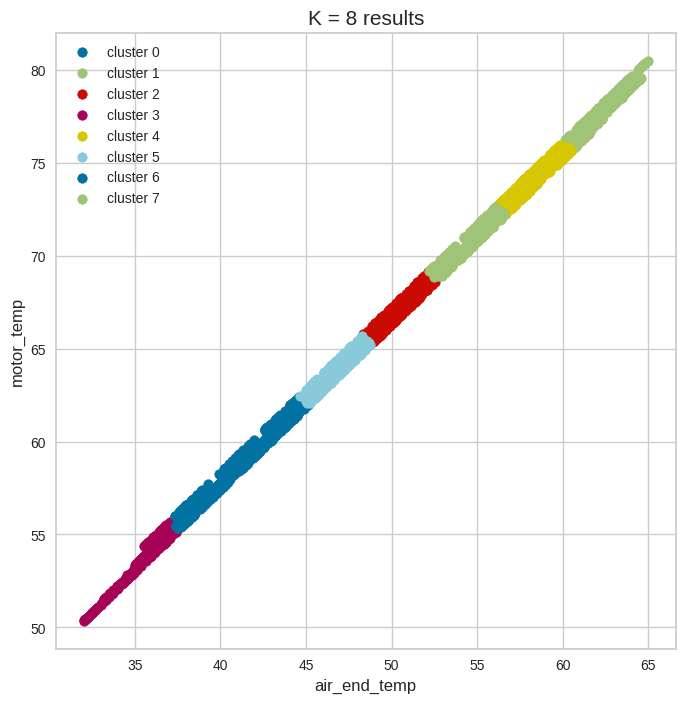

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df_train.loc[df_train['cluster'] == i, 'air_end_temp'], df_train.loc[df_train['cluster'] == i, 'motor_temp'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('air_end_temp', size = 12)
plt.ylabel('motor_temp', size = 12)
plt.show()

### train 데이터

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

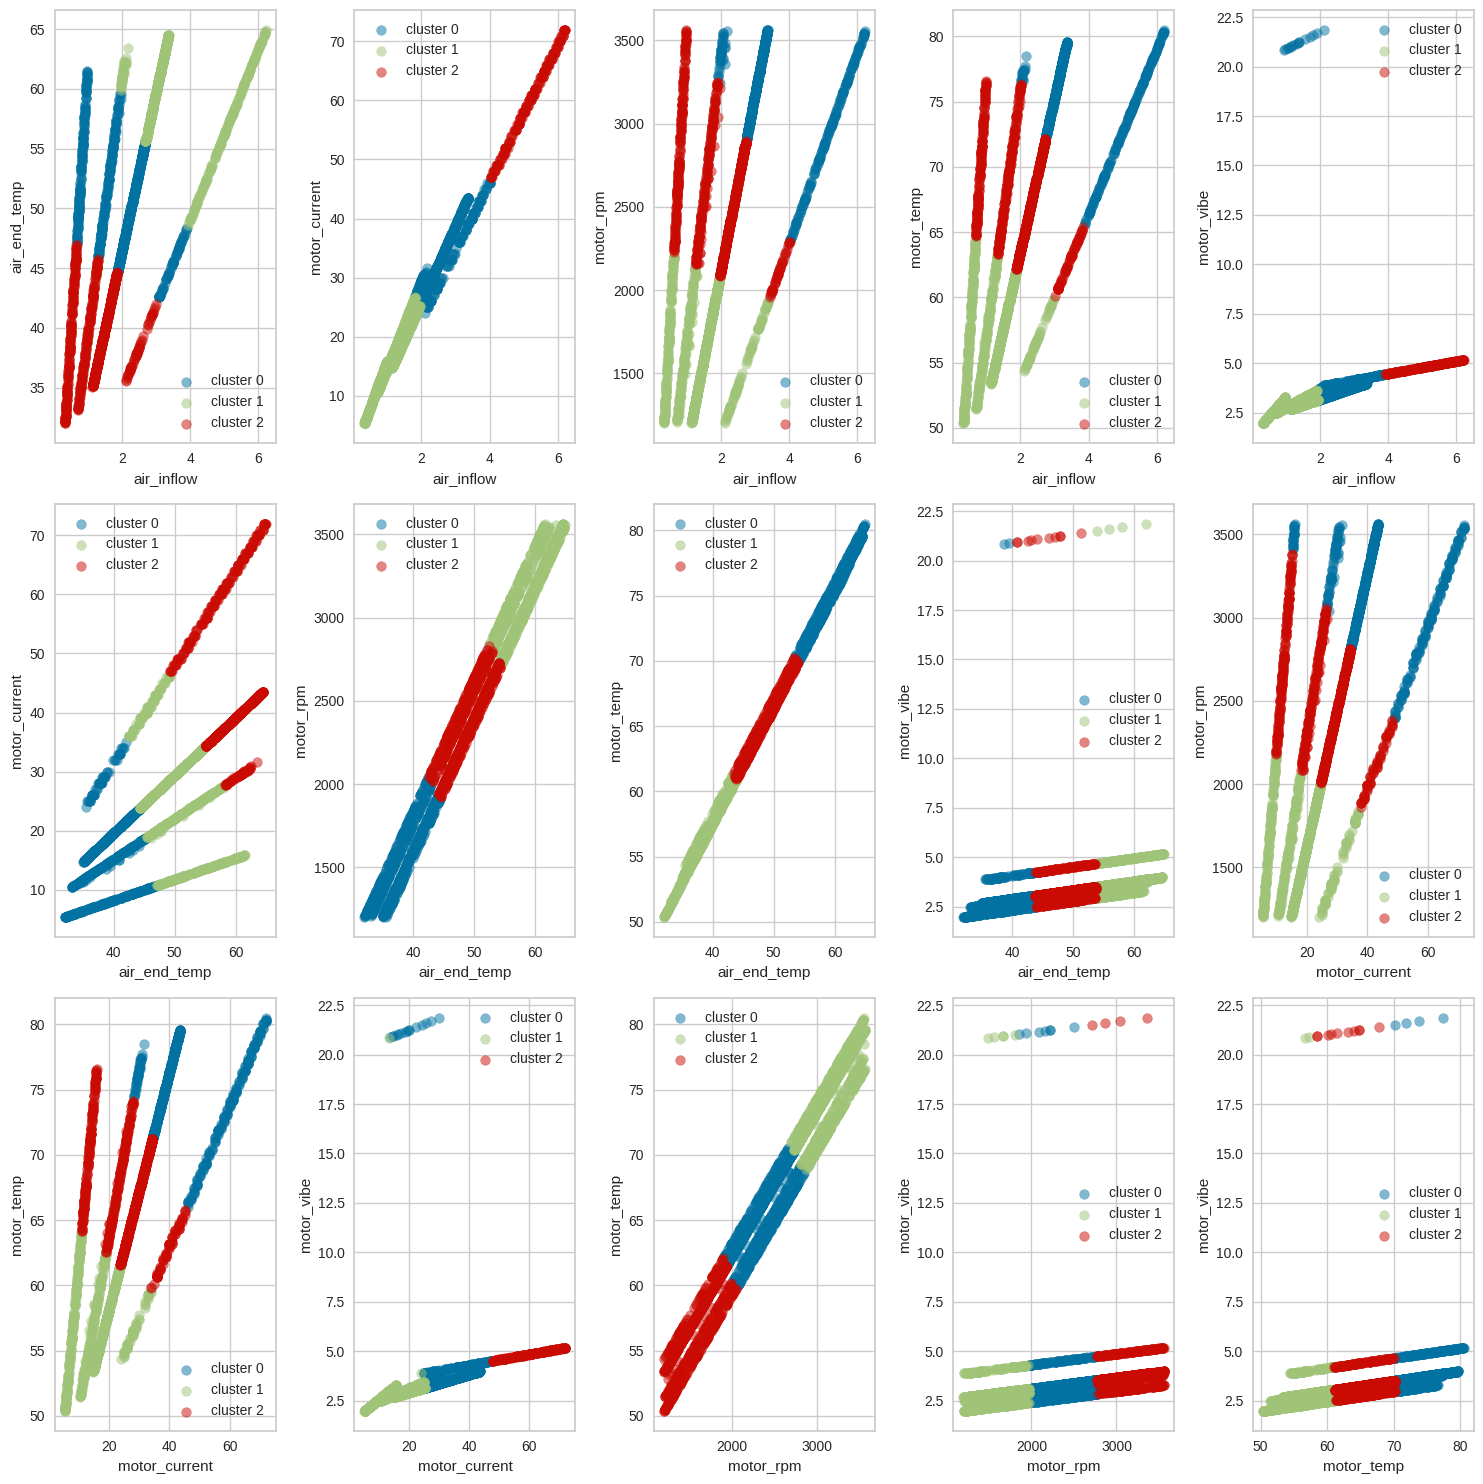

In [ ]:
from itertools import combinations

a = 'air_inflow'
b = 'air_end_temp'
c = 'motor_current'
d = 'motor_rpm'
e  = 'motor_temp'
f = 'motor_vibe'

# 그래프를 그릴 컬럼 선택
columns = [a, b, c, d, e, f]

# 그룹 수
k = 3

# MinMaxScaler 적용하여 데이터 정규화
scaler = MinMaxScaler()
df_train_scale = scaler.fit_transform(df_train[columns])

# 2개씩 조합하여 그래프 그리기
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,15))

for ax, (i, j) in zip(axes.flat, combinations(columns, 2)):

    # 모델 학습
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(df_train_scale[:, [columns.index(i), columns.index(j)]])

    # 각 데이터가 몇 번째 그룹에 속하는지 저장
    df_train['cluster'] = model.predict(df_train_scale[:, [columns.index(i), columns.index(j)]])

    # 산점도 그리기
    for cluster in range(k):
        ax.scatter(df_train.loc[df_train['cluster'] == cluster, i], df_train.loc[df_train['cluster'] == cluster, j], 
                   label = 'cluster ' + str(cluster), alpha = 0.5)

    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.legend()

plt.tight_layout()
plt.show()


### test 데이터


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

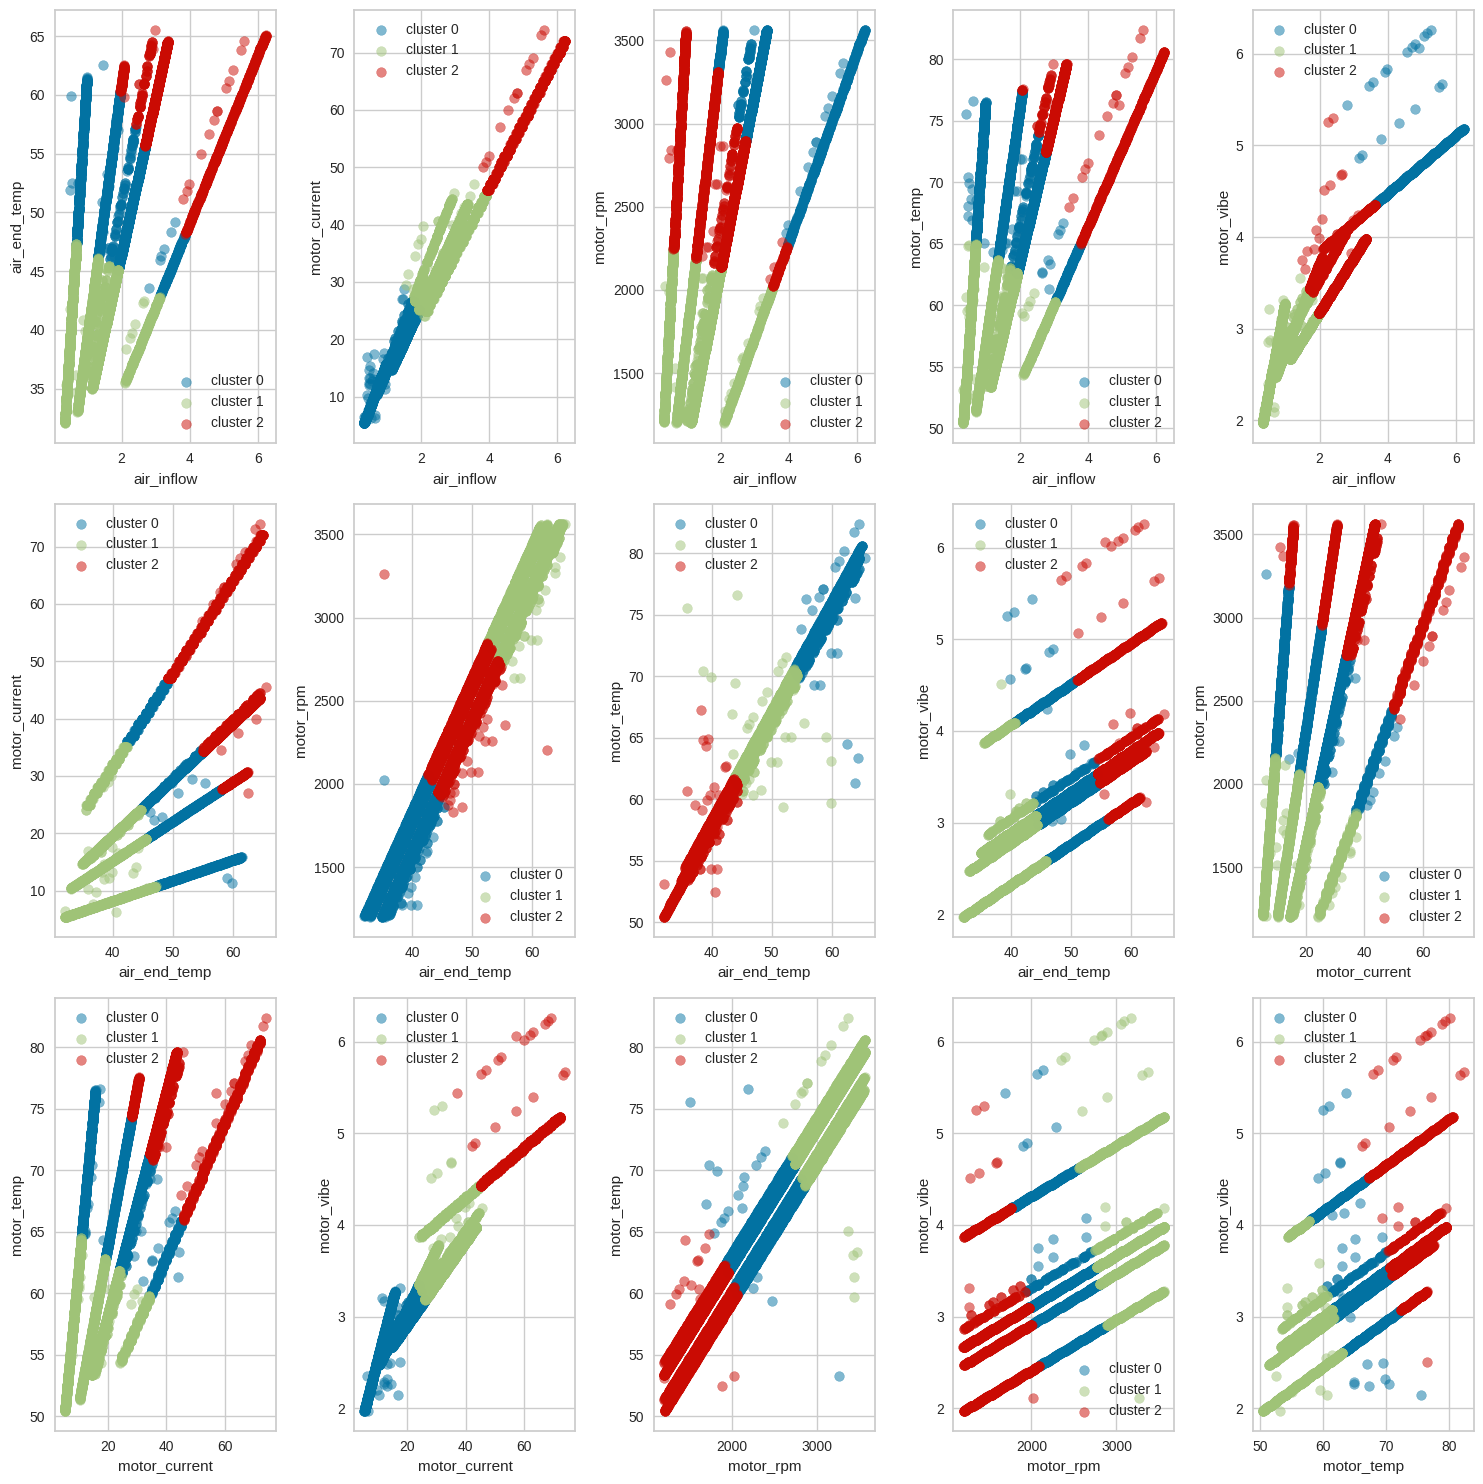

In [ ]:
from itertools import combinations

a = 'air_inflow'
b = 'air_end_temp'
c = 'motor_current'
d = 'motor_rpm'
e  = 'motor_temp'
f = 'motor_vibe'

# 그래프를 그릴 컬럼 선택
columns = [a, b, c, d, e, f]

# 그룹 수
k = 3

# MinMaxScaler 적용하여 데이터 정규화
scaler = MinMaxScaler()
df_test_scale = scaler.fit_transform(df_test[columns])

# 2개씩 조합하여 그래프 그리기
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,15))

for ax, (i, j) in zip(axes.flat, combinations(columns, 2)):

    # 모델 학습
    model = KMeans(n_clusters = k, random_state = 10)
    model.fit(df_test_scale[:, [columns.index(i), columns.index(j)]])

    # 각 데이터가 몇 번째 그룹에 속하는지 저장
    df_test['cluster'] = model.predict(df_test_scale[:, [columns.index(i), columns.index(j)]])

    # 산점도 그리기
    for cluster in range(k):
        ax.scatter(df_test.loc[df_test['cluster'] == cluster, i], df_test.loc[df_test['cluster'] == cluster, j], 
                   label = 'cluster ' + str(cluster), alpha = 0.5)

    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.legend()

plt.tight_layout()
plt.show()


## K-means 클러스터링 k 결정(Elbow Method)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

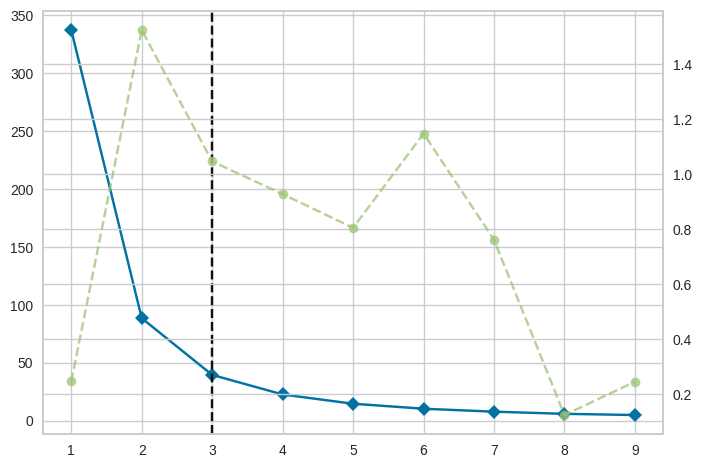

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

파란색이 각 데이터들의 군집 중심과의 평균 거리, 초록색은 학습 시간을 나타낸다.

#5.결과파일 내보내기

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_train)

predictions = kmeans.predict(df_test)
answer_df = pd.DataFrame({'Type': df_test['type'], 'label': predictions})

answer_df.to_csv('answer_sample2.csv', index=False)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
